## MNIST classifier neural net from scratch

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [5]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Initialize W&B project
wandb.init(project="mnist-classification", config={
    "epochs": 5,
    "batch_size": 64,
    "learning_rate": 0.01,
    "momentum": 0.9,
})

config = wandb.config

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# Define the Neural Network
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.flatten = nn.Flatten()  # Flatten 28x28 images into 784 input features
        self.fc1 = nn.Linear(28 * 28, 128)  # First fully connected layer
        self.relu1 = nn.ReLU()  # ReLU activation
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer
        self.relu2 = nn.ReLU()  # ReLU activation
        self.fc3 = nn.Linear(64, 10)  # Output layer (10 classes for digits 0-9)

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input
        x = self.relu1(self.fc1(x))  # Apply first layer + activation
        x = self.relu2(self.fc2(x))  # Apply second layer + activation
        x = self.fc3(x)  # Output logits
        return x

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Update the model and data to use the device
model = MNISTNet().to(device)  # Move model to GPU/CPU
criterion = nn.CrossEntropyLoss()  # Loss function does not need device specification
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum)

# Function to log images in validation phase
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    table = wandb.Table(columns=["image", "pred", "target"] + [f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        img_np = img.permute(1, 2, 0).numpy() * 255  # Convert to HWC and scale to [0, 255]
        table.add_data(wandb.Image(img_np), pred.item(), targ.item(), *prob.numpy())
    wandb.log({"predictions_table": table}, commit=False)

# Training Loop
for epoch in range(config.epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{config.epochs}], Loss: {avg_loss:.4f}")

    # Log training loss to W&B
    wandb.log({"epoch": epoch + 1, "train_loss": avg_loss})

# Evaluate the model
model.eval()
correct = 0
total = 0
logged_images = False  # Flag to log images only once during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Log images for the first batch
        if not logged_images:
            log_image_table(images, predicted, labels, probs)
            logged_images = True

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Finish W&B run
wandb.finish()

wandb: Currently logged in as: shreyak (shreyakchakraborty). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device: cpu
Epoch [1/5], Loss: 0.4326
Epoch [2/5], Loss: 0.1787
Epoch [3/5], Loss: 0.1315
Epoch [4/5], Loss: 0.1054
Epoch [5/5], Loss: 0.0887
Test Accuracy: 96.39%


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
epoch,5
test_accuracy,96.39
train_loss,0.08871


In [ ]:
# test with an image from disk

from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = "path_to_image.jpg"  # Replace with the path to your image
image = Image.open(image_path).convert("L")  # Convert to grayscale

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move image tensor to the same device as the model
image_tensor = image_tensor.to(device)

# Perform inference
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_label = torch.max(output, 1)

print(f"Predicted Label: {predicted_label.item()}")


## AlexNet PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def get_train_valid_loader(data_dir,
                               batch_size,
                               augment,
                               random_seed,
                               valid_size=0.1,
                               shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        valid_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
        ])
        if augment:
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
            ])

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=train_transform,
        )

        valid_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=valid_transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',                                      batch_size = 64,
                        augment = False,                                          random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [5]:
# setting the hyperparameters

num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

# Train the model
total_step = len(train_loader)

In [6]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Step [704/704], Loss: 1.3118
Accuracy of the network on the 5000 validation images: 60.54 %
Epoch [2/20], Step [704/704], Loss: 0.8509
Accuracy of the network on the 5000 validation images: 68.92 %
Epoch [3/20], Step [704/704], Loss: 1.0434
Accuracy of the network on the 5000 validation images: 69.12 %
Epoch [4/20], Step [704/704], Loss: 1.6783
Accuracy of the network on the 5000 validation images: 75.22 %
Epoch [5/20], Step [704/704], Loss: 0.1155
Accuracy of the network on the 5000 validation images: 74.58 %
Epoch [6/20], Step [704/704], Loss: 0.8936
Accuracy of the network on the 5000 validation images: 78.62 %
Epoch [7/20], Step [704/704], Loss: 0.4318
Accuracy of the network on the 5000 validation images: 77.72 %
Epoch [8/20], Step [704/704], Loss: 0.2691
Accuracy of the network on the 5000 validation images: 78.6 %
Epoch [9/20], Step [704/704], Loss: 0.1842
Accuracy of the network on the 5000 validation images: 79.98 %
Epoch [10/20], Step [704/704], Loss: 0.4344
Acc

In [7]:
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images, labels, outputs

  print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 81.84 %


In [11]:
torch.save(model.state_dict(), "trained_models/alexnet_cifar.pth")

In [12]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define image path
image_path = "test_samples/truck.jpeg"  # Replace with the actual image path

# Define the transformations to match AlexNet's expected input
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize to 227x227
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Load and transform the image
image = Image.open(image_path).convert("RGB")  # Ensure the image has 3 channels (RGB)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Print the tensor shape to verify
print(f"Transformed image shape: {image_tensor.shape}")

# Load your trained model
model = AlexNet()  # Reinitialize your AlexNet model (or import it if defined elsewhere)
model.load_state_dict(torch.load("trained_models/alexnet_cifar.pth"))  # Load the trained weights
model.eval()  # Set the model to evaluation mode

# Perform inference
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_class = torch.max(outputs, 1)

# Class labels for CIFAR-10
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Print the predicted label
print(f"Predicted Class: {classes[predicted_class.item()]}")


Transformed image shape: torch.Size([1, 3, 227, 227])
Predicted Class: truck


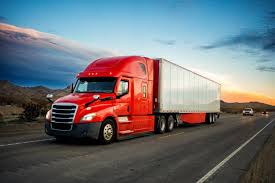

In [13]:
image